#This notebook outlines the QC for the chachie B reads.

###First we'll demultiplex the sequences using a QIIME script. Since we'll be using truncation length and max expected errors to filter seqeunces we'll turn off all the default QIIME QC paramaters in the demultiplexing script.

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


662


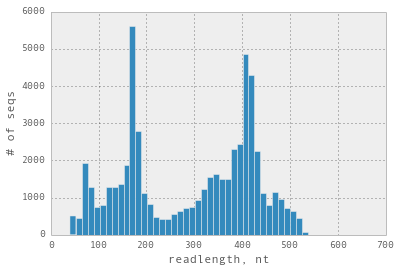

In [9]:
from cogent.parse.fasta import MinimalFastaParser
seq_lengths = []
for n, s in MinimalFastaParser(open("data/raw/B/combined.fasta")):
    seq_lengths.append(len(s))
seq_lengths = array(seq_lengths)
max_length =  seq_lengths.max()
print max_length
N, bins, bars = hist(seq_lengths, bins=50)
xlab = xlabel("readlength, nt")
ylab = ylabel("# of seqs")

###This is the demultiplexing command. (Note how some values are set at the max read length and some are zero. This effectively turns off these QC paramaters.)

In [10]:
!split_libraries_fastq.py \
-b data/raw/B/fastq/combined.fastq \
--store_demultiplexed_fastq \
-r 663 \
-p 0 \
-n 663 \
-q 0 \
--barcode_type 8 \
--max_barcode_errors 0 \
-i data/raw/B/fastq/combined.fastq \
-m data/chachie_mapper_B.txt \
-o data/demultiplexed_B

###Let's look at the log for the demultiplexing.

In [11]:
!head -n 20 data/demultiplexed_B/split_library_log.txt

Input file paths
Mapping filepath: data/chachie_mapper_B.txt (md5: 46eadd2eac10732e8a6508894615b344)
Sequence read filepath: data/raw/B/fastq/combined.fastq (md5: 069bb247bb3426a13e464fff6d111d97)
Barcode read filepath: data/raw/B/fastq/combined.fastq (md5: 069bb247bb3426a13e464fff6d111d97)

Quality filter results
Total number of input sequences: 56322
Barcode not in mapping file: 0
Read too short after quality truncation: 0
Count of N characters exceeds limit: 0
Illumina quality digit = 0: 0
Barcode errors exceed max: 0

Result summary (after quality filtering)
Median sequence length: 327.00
B4.24.7.10	6911
P1.24.7.70	5277
P3.15.7.10	5116
B1.24.7.10	5093
B3.24.7.10	4813


###This dataset has a peak at a low read length so lets remove sequences less than 250 characters to start.

250


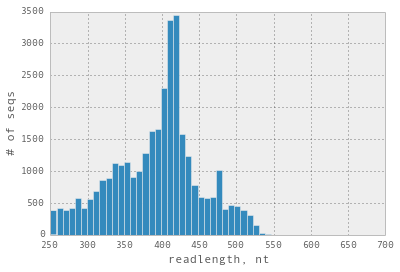

In [12]:
from cogent.parse.fastq import MinimalFastqParser
seq_lengths = []
out = open("data/demultiplexed_B/seqs_gt250.fastq", "w")
for n, s, q in MinimalFastqParser(open("data/demultiplexed_B/seqs.fastq"), strict=False):
    if len(s) >= 250:
        out.write("@%s\n%s\n+\n%s\n"%(n,s,q))
        seq_lengths.append(len(s))
out.close()
seq_lengths = array(seq_lengths)
min_length =  seq_lengths.min()
print min_length
N, bins, bars = hist(seq_lengths, bins=50)
xlab = xlabel("readlength, nt")
ylab = ylabel("# of seqs")

In [13]:
!head -n 4 data/demultiplexed_B/seqs_gt250.fastq

@B1.15.7.10_19 GXJS2L204JVUHI orig_bc=ACCGCACA new_bc=ACCGCACA bc_diffs=0
ACCGCACAGAGTTTGATCCTGGCTCAGGATGAACGCTAGCGGGAGGCTTAATACATGCAAGTCGAACGGCAGCATTTCGGATGGCAAGTGGCGAACGGGTGAGTAACGCGTACAGACCTGCCTTATACTGGAGGATAGCCCCGGGAAACTGGGAGTAATACTCCATGTGATCGTAAGATTAAAGCTCCGGCGGTATAAGATGGCTGTGCGTCTGATTAGCTAGTTGGTAAGGTAGTGGCTTACCAAGGCGACGATCAGTAGGGGCGTGAGAGCGTGGCCCCCACACGGTACGTN
+
FFFFFFFFFFE@@@HHHIGHGGIIIIIIHHHHIHHHHHHHHHHIHHHHHHHHFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEEEFAAAAFFFFFFFFFFFFFFFDDDFFFFFFFC?<<<FFFFFDDDFFFFFFFFFD@@@FFFFFFFFFFFFFFFFDDBBD?::::555=BBBBAAADFFFFFFFF???DDDDDA=9:8<<<<>><<1111@6AAA?==>=>>=////191??>>=??84!


###We'll use the maximum expected error threshold to cull poor quality sequences from those that remain. You can find the paper outlining this QC approach [here](http://www.nature.com/nmeth/journal/v10/n10/full/nmeth.2604.html).

###First we need to explore the data set further. We can use the "fastq_stats" subcommand in the usearch program to get a feel for how different maximum expected errors and truncation lengths will work with our data set.

In [14]:
!usearch -fastq_stats data/demultiplexed_B/seqs_gt250.fastq -log data/demultiplexed_B/stats.log

usearch v7.0.1001_i86linux32, 4.0Gb RAM (16.4Gb total), 8 cores
(C) Copyright 2013 Robert C. Edgar, all rights reserved.
http://drive5.com

Licensed to: chuck.peperanney@gmail.com

00:01  37Mb  100.0% Reading data/demultiplexed_B/seqs_gt250.fastq
     33179  Recs (33.2k), 0 too long                             
     392.6  Avg length
     13.0M  Bases


###...and we can look at the stats.

In [15]:
!head -n 10 data/demultiplexed_B/stats.log

usearch v7.0.1001_i86linux32, 4.0Gb RAM (16.4Gb total), 8 cores
usearch -fastq_stats data/demultiplexed_B/seqs_gt250.fastq -log data/demultiplexed_B/stats.log 
Started Thu Nov 21 11:16:09 2013

Read length distribution
      L           N      Pct   AccPct
-------  ----------  -------  -------
>=  518          47     0.1%     1.1%
    517          36     0.1%     1.2%
    516          33     0.1%     1.3%


###Unfortunately usearch doesn't provide the stats in a very useful format at the moment. All the stats are dumped in one file that is not easily parsed (ie it is meant to be human readable). I pulled out the relevant table for our data set and converted it to csv format and named the file "L_v_ee.csv". It is located in the "data" directory.

###We can read in the L_v_ee.csv file using the pandas module.

In [16]:
from pandas import read_csv
df = read_csv("data/demultiplexed_B/L_v_ee.csv", index_col=0, usecols=[0,5,6,7,8])

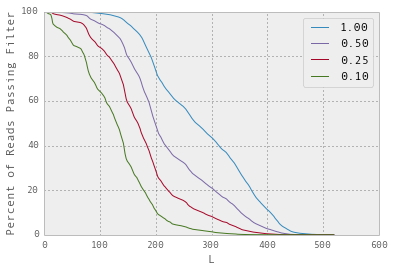

In [17]:
%matplotlib inline
ax = df.plot() #so simple with pandas!
fig = ax.get_figure()
ylab = ax.set_ylabel("Percent of Reads Passing Filter")

In [18]:
max_ee = "1.00"
truncation_length = 200
pct_retatined = df[max_ee][truncation_length] #this is the actual percentage of reads will keep with the above criteria
print pct_retatined

73.6


###Seems like we can use the max expected error of 1.00 and still retain approximately 70% of our reads if we truncate at 200 bases.

###We'll use usearch to filter reads given the above criteria and write the results to the tmp directory because we'll want to do a few extra steps before finalizing the QC.

In [19]:
!mkdir -p data/tmp

In [20]:
!usearch -fastq_filter data/demultiplexed_B/seqs_gt250.fastq \
-fastq_maxee "$max_ee" \
-fastq_trunclen "$truncation_length" \
-fastaout "data/tmp/maxee_trunc_B.fasta"

usearch v7.0.1001_i86linux32, 4.0Gb RAM (16.4Gb total), 8 cores
(C) Copyright 2013 Robert C. Edgar, all rights reserved.
http://drive5.com

Licensed to: chuck.peperanney@gmail.com

00:01 2.1Mb  100.0% Converting, 33.2k recs, 24166 converted (72.8%)
     33179  FASTQ recs (33.2k)                                     
         0  Short recs discarded (<200)
      9013  Low qual recs discarded (expected errs > 1.00)
     24166  Converted (24.2k, 72.8%)


###The following code finds and removes the forward primer. It's a bit more sophisticated than just clipping the sequences at a certain length so that it can find and remove primer sequences with indel and substitution errors. It's kind of slow to do all the pairwise alignments so be patient.

In [21]:
from qiime.split_libraries import local_align_primer_seq
from cogent.parse.fasta import MinimalFastaParser
from cogent import DNA
out = open("data/tmp/maxee_trunclen_B_primertrim.fasta", "w")
for n, s in MinimalFastaParser(open("data/tmp//maxee_trunc_B.fasta")):
    mm, pos = local_align_primer_seq(primer = DNA.makeSequence("GAGTTTGATCNTGGCTCAG").rc(), #linkerprimer from R&T 
                                     sequence=DNA.makeSequence(s).rc())
    s_trim_rc = DNA.makeSequence(s).rc()[:pos]
    s_trim = s_trim_rc.rc()
    out.write(">%s\n%s\n"%(n,s_trim))
out.close()

In [22]:
!head -n2 data/tmp/maxee_trunclen_B_primertrim.fasta
!head -n2 data/tmp/maxee_trunc_B.fasta

>B1.15.7.10_19 GXJS2L204JVUHI orig_bc=ACCGCACA new_bc=ACCGCACA bc_diffs=0
GATGAACGCTAGCGGGAGGCTTAATACATGCAAGTCGAACGGCAGCATTTCGGATGGCAAGTGGCGAACGGGTGAGTAACGCGTACAGACCTGCCTTATACTGGAGGATAGCCCCGGGAAACTGGGAGTAATACTCCATGTGATCGTAAGATTAAAGCTCCGGCGGTATAAGA
>B1.15.7.10_19 GXJS2L204JVUHI orig_bc=ACCGCACA new_bc=ACCGCACA bc_diffs=0
ACCGCACAGAGTTTGATCCTGGCTCAGGATGAACGCTAGCGGGAGGCTTAATACATGCAAGTCGAACGGCAGCATTTCGGATGGCAAGTGGCGAACGGGTGAGTAACGCGTACAGACCTGCCTTATACTGGAGGATAGCCCCGGGAAACTGGGAGTAATACTCCATGTGATCGTAAGATTAAAGCTCCGGCGGTATAAGA


###We won't worry about the reverse primer because we had to trim our reads well before the full amplicon length.

###Now we want to do some alignment based screening. Mothur is a useful tool for this purpose.

###First we need to make an alignment. We'll use SSU-Align to do this.

####Let's first make a Mothur group file.

In [23]:
!grep "^>" data/tmp/maxee_trunclen_B_primertrim.fasta | \
awk -F" " '{print $1}' | \
awk -F"_" 'BEGIN{OFS="\t"}{print $0,$1}' | \
sed 's/>//g' > data/tmp/group_file.txt

####First derepicate sequences. This command will produce a fasta file of unique sequences and a Mothur names file.

In [24]:
!mothur "#unique.seqs(fasta=data/tmp/maxee_trunclen_B_primertrim.fasta)" > /dev/null

####And we can make a count file for the current seqs from the group and name file combination (useful later).

In [25]:
!mothur "#count.seqs(name=data/tmp/maxee_trunclen_B_primertrim.names, group=data/tmp/group_file.txt)" > /dev/null
!head data/tmp/maxee_trunclen_B_primertrim.count_table

Representative_Sequence	total	B1.15.7.10	B1.24.7.10	B2.15.7.10	B2.24.7.10	B3.15.7.10	B3.24.7.10	B4.24.7.10	P1.15.7.10	P1.24.7.70	P2.15.7.10	P2.24.7.10	P3.15.7.10	P3.24.7.10	P4.24.7.10	
B1.15.7.10_19	19	4	0	0	0	0	2	1	0	0	0	12	0	0	0	
B1.15.7.10_20	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	
B1.15.7.10_21	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	
B1.15.7.10_23	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	
B1.15.7.10_28	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	
B1.15.7.10_38	3	1	0	0	0	0	0	0	0	0	1	1	0	0	0	
B1.15.7.10_42	162	26	47	0	0	20	0	25	30	9	0	0	2	0	3	
B1.15.7.10_47	3	1	1	0	0	0	0	1	0	0	0	0	0	0	0	
B1.15.7.10_49	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	


####Now call ssu-align.

In [26]:
!ssu-prep -x  --dna -f data/tmp/maxee_trunclen_B_primertrim.unique.fasta data/tmp/ssu-aln 6 > /dev/null

In [27]:
!./ssu-aln.ssu-align.sh

# Executing: ssu-align --dna data/tmp/ssu-aln/maxee_trunclen_B_primertrim.unique.fasta.1 data/tmp/ssu-aln/ssu-aln.1 > /dev/null &
# Executing: ssu-align --dna data/tmp/ssu-aln/maxee_trunclen_B_primertrim.unique.fasta.2 data/tmp/ssu-aln/ssu-aln.2 > /dev/null &
# Executing: ssu-align --dna data/tmp/ssu-aln/maxee_trunclen_B_primertrim.unique.fasta.3 data/tmp/ssu-aln/ssu-aln.3 > /dev/null &
# Executing: ssu-align --dna data/tmp/ssu-aln/maxee_trunclen_B_primertrim.unique.fasta.4 data/tmp/ssu-aln/ssu-aln.4 > /dev/null &
# Executing: ssu-align --dna data/tmp/ssu-aln/maxee_trunclen_B_primertrim.unique.fasta.5 data/tmp/ssu-aln/ssu-aln.5 > /dev/null &
# Executing: ssu-align --merge 6 --dna data/tmp/ssu-aln/maxee_trunclen_B_primertrim.unique.fasta.6 data/tmp/ssu-aln/ssu-aln.6
# ssu-align :: align SSU rRNA sequences
# SSU-ALIGN 0.1 (June 2010)
# Copyright (C) 2010 HHMI Janelia Farm Research Campus
# Freely distributed under the GNU General Public License (GPLv3)
# - - - - - - - - - - - - - - - - -

###Note that not all reads fit one of the provided SSU-Align covariance models. We'll have to account for these un-alignable (and probably poor quality or non-specific) reads later.

In [28]:
!head data/tmp/ssu-aln/ssu-aln.nomatch

B1.15.7.10_1905
B1.15.7.10_2294
B1.15.7.10_2997
B1.24.7.10_4593
B1.24.7.10_7157
B2.15.7.10_8315
B2.15.7.10_9191
B2.15.7.10_11052
B2.24.7.10_11518
B2.24.7.10_13836


In [29]:
!ssu-mask --dna --stk2afa -a data/tmp/ssu-aln/ssu-aln.bacteria.stk > /dev/null
!mv ssu-aln.bacteria* data/tmp/ssu-aln/

###This is what our reads that have passed QC so far look like.

In [30]:
!mothur "#summary.seqs(fasta=data/tmp/ssu-aln/ssu-aln.bacteria.afa, count=data/tmp/maxee_trunclen_B_primertrim.count_table)"







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=data/tmp/ssu-aln/ssu-aln.bacteria.afa, count=data/tmp/maxee_trunclen_B_primertrim.count_table)

Using 1 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	29	423	107	0	3	1
2.5%-tile:	30	535	151	0	3	604
25%-tile:	30	614	168	0	4	6035
Median: 	30	624	172	0	5	12070
75%-tile:	30	665	173	0	5	18105
97.5%-tile:	35	671	173	0	5	23536
Maximum:	535	776	178	0	7	24139
Mean:	30.6994	618.549	169.775	0	4.4554
# of un

###Let's remove seqs that don't appear to align to the expected amplicon region.

In [31]:
!mothur "#screen.seqs(start=31, end=532, fasta=data/tmp/ssu-aln/ssu-aln.bacteria.afa, maxhomop=8, count=data/tmp/maxee_trunclen_B_primertrim.count_table)" > /dev/null
!cp data/tmp/ssu-aln/ssu-aln.bacteria.good.afa data/tmp/aln.good.fasta
!mothur "#filter.seqs(fasta=data/tmp/aln.good.fasta, vertical=t)" > /dev/null
!mothur "#summary.seqs(fasta=data/tmp/aln.good.filter.fasta, count=data/tmp/ssu-aln/maxee_trunclen_B_primertrim.good.count_table)"







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=data/tmp/aln.good.filter.fasta, count=data/tmp/ssu-aln/maxee_trunclen_B_primertrim.good.count_table)

Using 1 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	446	138	0	3	1
2.5%-tile:	2	450	153	0	3	512
25%-tile:	2	498	170	0	4	5119
Median: 	2	538	172	0	5	10238
75%-tile:	2	540	173	0	5	15357
97.5%-tile:	2	585	173	0	5	19964
Maximum:	3	611	178	0	7	20475
Mean:	1.9998	527.508	170.316	0	4.65123
# of uniq

###The following code trims our reads so that they all start and end at the same position in the 16S gene.

111 172 146.024586173


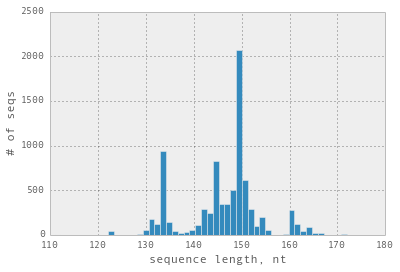

In [32]:
from cogent.parse.fasta import MinimalFastaParser
from cogent import DNA
out = open("data/tmp/aln.good.filter.filter.fasta", "w")
lengths = []
start = 2
end = 446

for n, s in MinimalFastaParser(open("data/tmp/aln.good.filter.fasta")):
    s_nodots = s.replace(".","-")
    out.write(">%s\n%s\n"%(n, str(DNA.makeSequence(s_nodots)[start:end].degap())))
    lengths.append(len(DNA.makeSequence(s_nodots)[start:end].degap()))

out.close()
    
lengths = array(lengths)
print lengths.min(), lengths.max(), lengths.mean()
N, bins, bars = hist(lengths, bins=50)
xlab = xlabel("sequence length, nt")
ylab = ylabel("# of seqs")

###That looks much better.

###We can use mothur to run uchime as well.

In [33]:
!mothur "#chimera.uchime(fasta=data/tmp/aln.good.filter.filter.fasta, reference=self, count=data/tmp/ssu-aln/maxee_trunclen_B_primertrim.good.count_table, dereplicate=t)" > /dev/null 2>&1 

In [34]:
!wc -l data/tmp/aln.good.filter.filter.uchime.accnos

274 data/tmp/aln.good.filter.filter.uchime.accnos


In [35]:
!head data/tmp/aln.good.filter.filter.uchime.accnos

B1.24.7.10_3605
P2.15.7.10_39119
B1.15.7.10_377
B1.24.7.10_3579
B1.24.7.10_6042
B1.24.7.10_5842
B1.15.7.10_1636
B3.15.7.10_15179
B2.15.7.10_9478
P1.15.7.10_29084


###Lastly we should removed plastid genome sequences that our primers have amplified. To do this, we first need to identify the plastid sequences.

In [36]:
!mothur "#classify.seqs(fasta=data/tmp/aln.good.filter.filter.fasta, reference=ref_db/rdp/trainset9_032012.rdp.fasta, taxonomy=ref_db/rdp/trainset9_032012.rdp.tax, cutoff=80)" > /dev/null

####We have this many chloroplast or "unknown" sequences in our non-redundant reads to this point.

In [37]:
!egrep -c "Chloroplast|unknown" data/tmp/aln.good.filter.filter.rdp.wang.taxonomy

71


####Make a list the "accnos" for the chloroplast|unknown seqs we want to remove...

In [38]:
!egrep "Chloroplast|unknown" data/tmp/aln.good.filter.filter.rdp.wang.taxonomy | \
awk '{print $1}' > data/tmp/chloroplast_or_unknown.accnos

###...and remove the chimeras from the fasta file (in addition to seqs that SSU-Align couldn't find an appropriate model for).

In [39]:
!cat data/tmp/ssu-aln/ssu-aln.nomatch \
data/tmp/aln.good.filter.filter.uchime.accnos \
data/tmp/chloroplast_or_unknown.accnos | \
sort | uniq > data/tmp/to_remove.accnos

In [40]:
!head data/tmp/to_remove.accnos

B1.15.7.10_1120
B1.15.7.10_1130
B1.15.7.10_1161
B1.15.7.10_1199
B1.15.7.10_1201
B1.15.7.10_1224
B1.15.7.10_1283
B1.15.7.10_1340
B1.15.7.10_1411
B1.15.7.10_1480


In [41]:
!mothur "#remove.seqs(accnos=data/tmp/to_remove.accnos, fasta=data/tmp/aln.good.filter.filter.fasta, count=data/tmp/ssu-aln/maxee_trunclen_B_primertrim.good.count_table)" > /dev/null

In [42]:
!mothur "#summary.seqs(fasta=data/tmp/aln.good.filter.filter.pick.fasta, count=data/tmp/ssu-aln/maxee_trunclen_B_primertrim.good.pick.count_table)"







mothur v.1.32.1
Last updated: 10/16/2013

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > summary.seqs(fasta=data/tmp/aln.good.filter.filter.pick.fasta, count=data/tmp/ssu-aln/maxee_trunclen_B_primertrim.good.pick.count_table)

Using 1 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	111	111	0	3	1
2.5%-tile:	1	131	131	0	3	500
25%-tile:	1	144	144	0	4	4995
Median: 	1	149	149	0	5	9990
75%-tile:	1	151	151	0	5	14984
97.5%-tile:	1	162	162	0	5	19479
Maximum:	1	172	172	0	7	19978
Mean:	1	146.417	146.417	0	4.4870

###Now we have our final QC'd set of sequences. We'll copy it out of the data/tmp directory and rename it something shorter.

####First we have to make a name file that is consistent with our final fasta.

In [43]:
from cogent import DNA, LoadSeqs
aln = LoadSeqs("data/tmp/aln.good.filter.filter.pick.fasta", aligned=False, moltype=DNA)
keepers = aln.Names
out = open("data/tmp/aln.good.filter.filter.pick.names", "w")
for line in open("data/tmp/maxee_trunclen_B_primertrim.names"):
    if line.split()[0] in keepers:
        out.write(line)
out.close()

In [44]:
!mothur "#deunique.seqs(fasta=data/tmp/aln.good.filter.filter.pick.fasta, name=data/tmp/aln.good.filter.filter.pick.names)" > /dev/null

In [45]:
!cp data/tmp/aln.good.filter.filter.pick.redundant.fasta data/finalQC_B.fasta

In [1]:
!grep -c ">" data/finalQC_B.fasta
!grep -c ">" data/raw/B/combined.fasta
!head data/finalQC_B.fasta

19978
56322
>B1.15.7.10_21
ACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGAGGGCCCAGAGCTTGCTCTGGAGACCCGAGTGGCGAACGGGTGAGTAACACGTGACCAACCTGTCCTAGGGTGGGGGACAACCCGGGGAAACCTGGGCTAATACCGCA
>B1.15.7.10_63
ACGAACGTTGGCGGCGTGGATGAGGCATGCAAGTCGCGCGTGAAAGCTCCTTCGGGAGTGAGTAAAGCGGCGAACGGGTGAGTAACACGTAATCAAGCTGCCCCCGAGACCGGGATAACCACGGGAAACTGTGGCTAATACCGGA
>B1.15.7.10_142
ACGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAGCGCTTCCCTTCGGGGAGGAGCGGCGGACGGGTTAGTAACGCGTGGGAACATACCCTTTTCTAAGGAATAGCCTCGGGAAACTGAGAGTAATACCTTA
>B1.24.7.10_3494
ACGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAGCGCTTCCCTTCGGGGAGGAGCGGCGGACGGGTTAGTAACGCGTGGGAACATACCCTTTTCTAAGGAATAGCCTCGGGAAACTGAGAGTAATACCTTA
>B1.15.7.10_154
GCGAACGCTAGCGGGAGGCTTAACACATGCAAGTCGAGCGCTCAACTTCGGTTGAGAGCGGCGGACGGGTGAGTAACACGTAGGTTACCTGCCCTTTGGTGGGGGAGTAACTCTAGGAAACTGGAGCTAATACCGCA
